### Figure generation notebook for Merlin analysis

In [1]:
!pip install matplotlib-scalebar
!pip install fs

In [2]:
import fs
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import seaborn as sns
from skimage.io import imread
import tifffile
from fs import open_fs
import h5py
import string
from merlin.core import dataset

plt.ion()

In [3]:
# Load raw MERFISH results
# Define the path of the analyzed data

data_path = '/mnt/ibm_sm/home/pranathi/merlin_analysis/'

# Define the experiment

experiment_name = 'Mskidney_CellBoundary_VZG116_061721'

d_set = dataset.MERFISHDataSet(experiment_name)
fs = open_fs(os.path.join(data_path, experiment_name))

print('Dataset loaded.')

Dataset loaded.


In [4]:
z_index = 3
fov = 100
transformation_matrix = np.loadtxt(
    os.path.join(data_path, experiment_name, "BlendMosaic", "region_0", 'micron_to_mosaic_pixel_transform.csv'))
size_of_one_pixel = 1 / transformation_matrix[0, 0]
print(transformation_matrix[0, 0], size_of_one_pixel)

9.259495735168457 0.10799724181543749


### Panel A: Original mosaic for the whole dataset

(725, 720, 4)


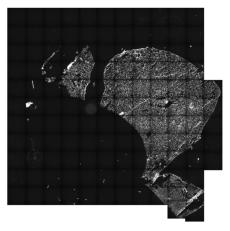

In [5]:
# Load original mosaic captured at the beginning og the experiment
original_mosaic = imread("/mnt/vizgene/Msliver_Cellboundary_PM1_12182020/mosaic.png")
original_mosaic = original_mosaic[36: original_mosaic.shape[0] - 36, 256: original_mosaic.shape[1] - 256]
plt.axis("off")
print(original_mosaic.shape)
plt.imshow(original_mosaic)

### Panel B: Dapi mosaic for only the selected region's z slice

In [6]:
dapi_mosaic = tifffile.TiffFile(os.path.join(
    data_path, experiment_name, "BlendMosaic", "region_0" , 'mosaic_DAPI_z3.tif')).asarray()
print(dapi_mosaic.shape)

(42793, 39089)


uint16


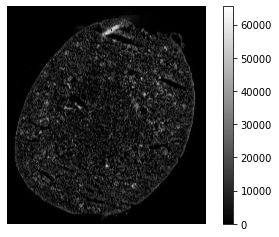

In [7]:
print(dapi_mosaic.dtype)
plt.axis("off")
plt.imshow(dapi_mosaic, cmap='gray')
plt.colorbar()

In [8]:
vmin=np.min(dapi_mosaic)
vmax=np.max(dapi_mosaic)
print(vmin, vmax)

0 65506


### Panel C: Input unaligned image

(2048, 2048)
uint16


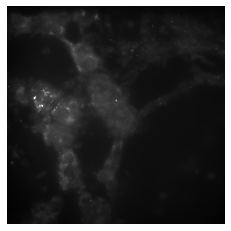

In [9]:
input_image = d_set.get_raw_image(
    0, fov, d_set.z_index_to_position(z_index))
print(input_image.shape)
print(input_image.dtype)
plt.axis("off")
plt.imshow(input_image, cmap='gray', vmin=np.min(input_image), vmax=10000)

### Panel D: Fiducial aligned image

In [ ]:
fiducial_aligned_image = tifffile.TiffFile(os.path.join(
    data_path, experiment_name, "FiducialCorrelationWarp", "images" , 'aligned_fiducial_images{}.tif'.format(fov))).asarray()
print(fiducial_aligned_image.shape)
print(fiducial_aligned_image.dtype)
plt.axis("off")
plt.imshow(fiducial_aligned_image[0, :, :], cmap='gray')

### Panel removed - Deconvolved image - looks like all zeros

In [14]:
d_task = d_set.load_analysis_task("DeconvolutionPreprocessGuo")
print(d_task)

In [15]:
print(d_task._image_name(fov))

/mnt/ibm_lg/pranathi/vizgen_results/merlin_analysis_may26_merlin0.1.9_with_images_enabled_for_steps//Msliver_Cellboundary_PM1_12182020/DeconvolutionPreprocessGuo/preprocessed_images/fov_100.tif


(16, 2048, 2048)
uint16
8078619042


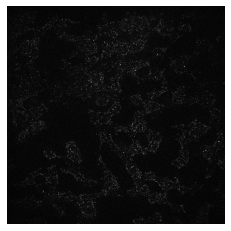

In [19]:
deconvolved_image = d_task.get_processed_image_set(fov, z_index)
print(deconvolved_image.shape)
print(deconvolved_image.dtype)
print(np.sum(deconvolved_image))

plt.axis("off")
plt.imshow(deconvolved_image[0, :, :], cmap='gray', vmax=4000)

### Panel E: Decoded image

In [11]:
decoded_image = tifffile.TiffFile(os.path.join(
    data_path, experiment_name, "Decode", "images" , 'decoded{}.tif'.format(fov))).asarray()
print(decoded_image.shape)
plt.axis("off")
plt.imshow(decoded_image[z_index, :, :], cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ibm_sm/home/pranathi/merlin_analysis/Mskidney_CellBoundary_VZG116_061721/Decode/images/decoded100.tif'

### Panel F: Boundary image

<ipython-input-12-a4109bb571d0>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  cell_boundaries = h5py.File(current_file)


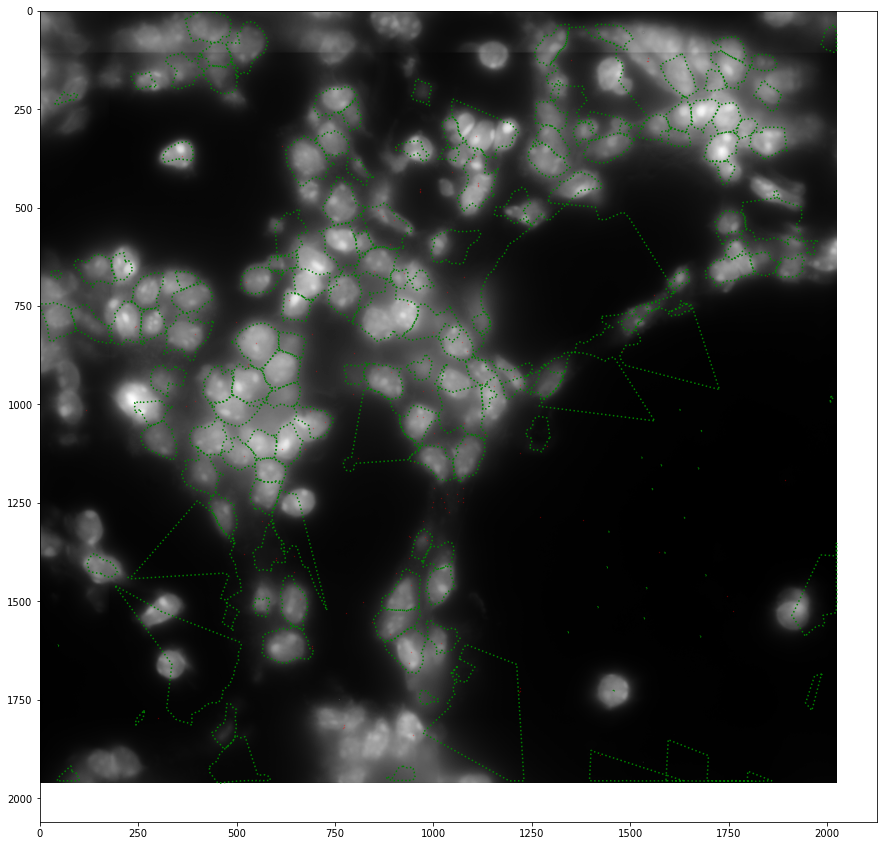

In [12]:
cell_metadata = pd.read_csv(os.path.join(
    data_path, experiment_name, 'ExportCellMetadata/region_0/feature_metadata.csv'), index_col=0)
with fs.open(os.path.join('RefineCellDatabases', 'features', 'feature_data_%i.hdf5' % fov), 'rb') as current_file:
    cell_boundaries = h5py.File(current_file)
    current_cells = []
    for i in cell_metadata[cell_metadata['fov'] == fov].index:
        if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % z_index]:
            temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % z_index]['p_0']['coordinates'][0])
            boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
            boundary_polygon[:, :-1] = temp
            transformed_boundary = np.matmul(transformation_matrix, np.transpose(boundary_polygon))[:-1]
            current_cells.append(transformed_boundary)
min_coord = np.min([np.min(x, axis=1) for x in current_cells], axis=0).astype(int)
max_coord = np.max([np.max(x, axis=1) for x in current_cells], axis=0).astype(int)       

detected_transcripts = pd.read_csv(os.path.join(
    data_path, experiment_name, 'ExportBarcodes/region_0/barcodes.csv'), index_col=0)
active_transcripts = detected_transcripts[detected_transcripts['fov'] == fov].copy()
temp = active_transcripts[['global_x', 'global_y']].values
transcript_positions = np.ones((temp.shape[0], temp.shape[1]+1))
transcript_positions[:, :-1] = temp
transformed_positions = np.matmul(transformation_matrix, np.transpose(transcript_positions))[:-1]
active_transcripts.loc[:, 'local_x'] = transformed_positions[0, :]
active_transcripts.loc[:,'local_y'] = transformed_positions[1, :]

plt.figure(figsize=(15,15))
plt.imshow(dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]], cmap=plt.cm.gray)

for tb in current_cells:
    plt.plot(tb[0]-min_coord[0], tb[1] - min_coord[1], 'g', linestyle=':')

points = [active_transcripts['local_y'] - min_coord[1], active_transcripts['local_x'] - min_coord[0]]
plt.scatter(
    points[1],
    points[0],color='r',s=0.1, alpha=0.5)

In [13]:
# Remove transcripts out of bounds

x = points[1].tolist()
y = points[0].tolist()
print(len(x))
print(len(y))
x_new = []
y_new = []
for p1, p2 in zip(x, y):
    if (p2 > 1 and p2 < decoded_image.shape[1] -1) and (p1 > 1 and p1 < decoded_image.shape[2] -1):
        y_new.append(p2)
        x_new.append(p1)
print(len(x_new))
print(len(y_new))

142
142


NameError: name 'decoded_image' is not defined

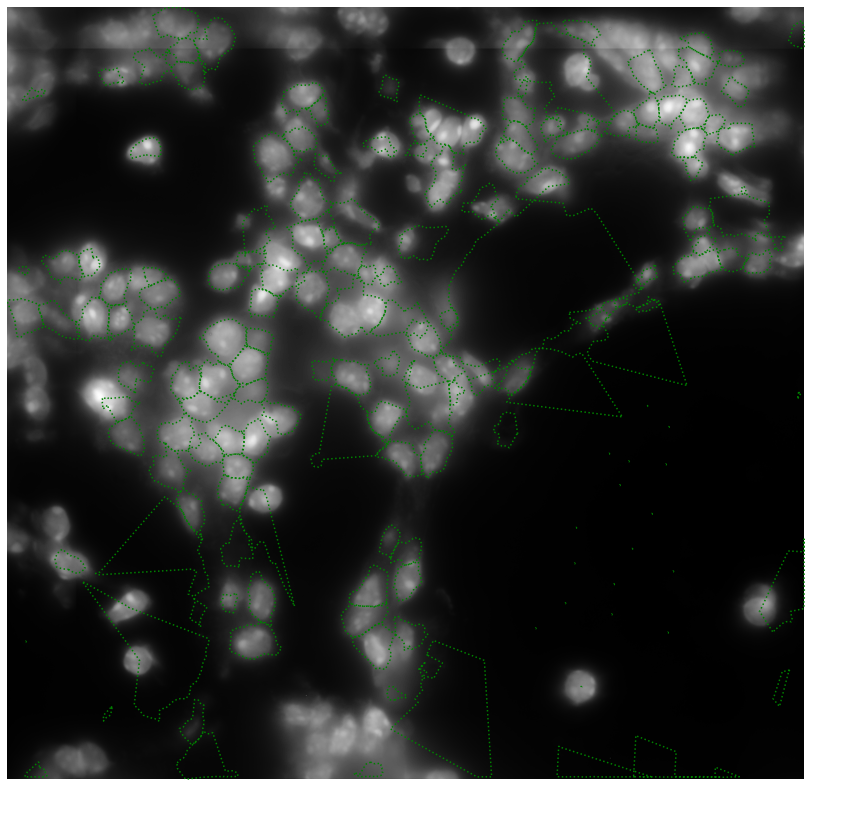

In [14]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]], cmap=plt.cm.gray)

for tb in current_cells:
    plt.plot(tb[0]-min_coord[0], tb[1] - min_coord[1], 'g', linestyle=':')

points = [active_transcripts['local_y'] - min_coord[1], active_transcripts['local_x'] - min_coord[0]]
plt.scatter(
    x_new,
    y_new,color='r',s=0.1, alpha=0.5)

### Plot combined figure

In [15]:
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('svg', fonttype='none')

In [ ]:
# Plot the whole figure
heights = [2048] * 1
widths = [2048] * 2

fig_width = 8.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

fig, ax = plt.subplots(1,2, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})
# ax[0, 0].axis("off")
# ax[0, 0].imshow(original_mosaic, cmap="gray")
# scalebar = ScaleBar(0.009, "mm", color='w', box_color='w', box_alpha=0, location='upper left')
# ax[0, 0].add_artist(scalebar)

# Panel A
ax[0].axis("off")
ax[0].imshow(dapi_mosaic, cmap="gray")
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
ax[0].add_artist(scalebar)

                  
# Panel C
# ax[1, 0].axis("off")
# ax[1, 0].imshow(fiducial_aligned_image[0, :, :], cmap="gray")
# scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
# ax[1, 0].add_artist(scalebar)

# # Panel D
# ax[1, 1].axis("off")
# ax[1, 1].imshow(deconvolved_image[0, :, :], cmap="gray", vmax=4000)
# scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
# ax[1, 1].add_artist(scalebar)


# Panel E
# ax[2, 0].axis("off")
# ax[2, 0].imshow(decoded_image[0, :, :], cmap="gray")
# scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
# ax[2, 0].add_artist(scalebar)

# Panel F
ax[1].axis("off")
ax[1].imshow(dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]], cmap=plt.cm.gray)

for tb in current_cells:
    ax[1].plot(tb[0]-min_coord[0], tb[1] - min_coord[1], 'g', linestyle=':')
ax[1].scatter(
    x_new,
    y_new,color='r',s=0.1, alpha=0.5)
scalebar = ScaleBar(size_of_one_pixel, "um", color='w',box_color='w', box_alpha=0)
ax[1].add_artist(scalebar)

# Label subpanels
axes = ax.flat
for n, ax in enumerate(axes):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
fig.tight_layout()

In [52]:
# Export figures
fig.savefig('Fig2_merlin_image_analysis_kidney.pdf')
fig.savefig('Fig2_merlin_image_analysis_kidney.png')